In [1]:
!pip -q install transformers #installing because we want to use pre_trained models, both from huggingface and our own models
!wget -q https://github.com/DavVratChadha/NoPunIntended/raw/main/data/tag_dict.pickle #loading the relative frequency heuristic
!wget -q https://github.com/DavVratChadha/NoPunIntended/raw/main/data/dataloaders_deberta.pickle
!wget -q https://github.com/DavVratChadha/NoPunIntended/raw/main/data/dataloaders_roberta.pickle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 7.3 MB/s eta 0:00:00


In [2]:
import pickle
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [3]:
#function to load pickle files
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f, fix_imports = True)
    return data

#loading the pickle files
(train_dataloader_roberta, val_dataloader_roberta, test_dataloader_roberta) = load_pickle('dataloaders_roberta.pickle')
(train_dataloader_deberta, val_dataloader_deberta, test_dataloader_deberta) = load_pickle('dataloaders_deberta.pickle')

In [4]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

#Our Fine-Tuned Models
roberta_model = AutoModelForSequenceClassification.from_pretrained("DVC12/NoPunIntended_RoBERTa")
deberta_model = AutoModelForSequenceClassification.from_pretrained("DVC12/NoPunIntended_DeBERTa")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
deberta_model.to(device)
roberta_model.to(device)
print(["Using CPU", "Using Cuda"][int(torch.cuda.is_available())])


Using Cuda


In [5]:
#function to calculate accuracy of the model for a given batch of data
def accuracy(roberta_model_output, deberta_model_output, ground_truth_labels, rel_freq_heuristic, w1, w2):
  roberta_model_output = torch.softmax(roberta_model_output, dim = 1) * rel_freq_heuristic.cpu()
  #renormalizing
  sum = torch.sum(roberta_model_output)
  roberta_model_output = roberta_model_output/sum
  roberta_model_pred = torch.argmax(roberta_model_output, dim=1)
  roberta_model_pred = np.array(roberta_model_pred)
  roberta_conf = torch.max(roberta_model_output, dim = 1)[0][0].item()

  deberta_model_output = torch.softmax(deberta_model_output, dim = 1) * rel_freq_heuristic.cpu()
  #renormalizing
  sum = torch.sum(deberta_model_output)
  deberta_model_output = deberta_model_output/sum
  deberta_model_pred = torch.argmax(deberta_model_output, dim=1)
  deberta_model_pred = np.array(deberta_model_pred)
  deberta_conf = torch.max(deberta_model_output, dim = 1)[0][0].item()

  if w1 * roberta_conf > w2 * deberta_conf:
    final_output = roberta_model_pred
  else:
    final_output = deberta_model_pred

  ground_truth_labels = np.array(ground_truth_labels.detach().cpu())

  #checking how many values in model_output are equal to their corresponding values in ground_truth_labels
  num_correct = np.sum(final_output == ground_truth_labels)
  accuracy_val = num_correct / len(ground_truth_labels)
  return accuracy_val

In [6]:
roberta_batches = []
deberta_batches = []

#unloading the dataloaders
for batch in test_dataloader_roberta:
  roberta_batches.append(batch)

i = 0
for batch in test_dataloader_deberta:
  i+=1
  for k in range(len(batch)):
    temp_list = []
    for j in range(4):      
      if k >= len(batch[j]):
        continue
      temp_list.append(batch[j][k])
    deberta_batches.append(temp_list)


deberta_batches = deberta_batches[:-2]

del test_dataloader_roberta, test_dataloader_deberta

In [7]:
print(len(roberta_batches))
print(len(deberta_batches))

430
430


In [8]:
roberta_model.eval()
deberta_model.eval()
test_acc_array = []
for w1 in np.arange(0.45, 1.05, 0.05):
  for w2 in np.arange(0.45, 1.05, 0.05):
    if w1 == w2:
      continue
    total_test_acc = 0

    for index, (batch_roberta, batch_deberta) in enumerate(zip(roberta_batches, deberta_batches)):
        input_ids_roberta, attention_mask_roberta, labels_roberta, rel_freq_heuristic_roberta = batch_roberta
        input_ids_roberta, attention_mask_roberta, labels_roberta, rel_freq_heuristic_roberta = input_ids_roberta.to(device), attention_mask_roberta.to(device), labels_roberta.to(device), rel_freq_heuristic_roberta.to(device)

        input_ids_deberta, attention_mask_deberta, labels_deberta, rel_freq_heuristic_deberta = batch_deberta
        input_ids_deberta, attention_mask_deberta, labels_deberta, rel_freq_heuristic_deberta = input_ids_deberta.to(device), attention_mask_deberta.to(device), labels_deberta.to(device), rel_freq_heuristic_deberta.to(device)
      
        with torch.no_grad():
            roberta_outputs = roberta_model(input_ids_roberta, attention_mask = attention_mask_roberta, labels = labels_roberta)
            roberta_output_data = roberta_outputs[1].detach().cpu()

            deberta_outputs = deberta_model(input_ids_deberta.unsqueeze(0), attention_mask = attention_mask_deberta.unsqueeze(0), labels = labels_roberta)
            deberta_output_data = deberta_outputs[1].detach().cpu()

            #calculating accuracy for batch
            total_test_acc += accuracy(roberta_output_data, deberta_output_data, labels_roberta, rel_freq_heuristic_roberta, w1, w2)

        # Delete unnecessary values to save memory
        del input_ids_roberta, attention_mask_roberta, labels_roberta, rel_freq_heuristic_roberta, input_ids_deberta, attention_mask_deberta, labels_deberta, rel_freq_heuristic_deberta, roberta_outputs, deberta_outputs

    #Calculate average test accuracy
    avg_test_acc = total_test_acc / len(roberta_batches)
    test_acc_array.append((avg_test_acc, w1, w2))


In [31]:
max_tuple = max(test_acc_array, key = lambda x: x[0])
print(max_tuple[1:])

(0.6499999999999999, 0.8499999999999999)


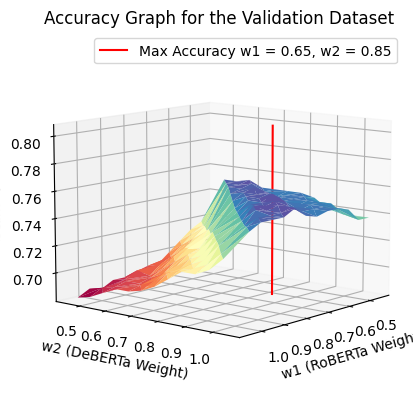

In [47]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import Delaunay
import numpy as np

#extract x, y, and z coordinates from the data
z_coords, x_coords, y_coords = zip(*test_acc_array)

#create a 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#create the Delaunay triangulation
tri = Delaunay(np.array(list(zip(x_coords, y_coords))))

#plot the data as a mesh
ax.plot_trisurf(x_coords, y_coords, z_coords, triangles = tri.simplices, cmap = plt.cm.Spectral)
ax.view_init(azim = 40, elev = 10)

z_min = min(z_coords)
z_max = max(z_coords)
x_line = [0.65] * 2
y_line = [0.85] * 2
z_line = [z_min, z_max + 0.05]
ax.plot(x_line, y_line, z_line, color = 'red', label = "Max Accuracy w1 = 0.65, w2 = 0.85")

#set labels for the axes
ax.set_xlabel('w1 (RoBERTa Weight)')
ax.set_ylabel('w2 (DeBERTa Weight)')
ax.set_zlabel('Accuracy')
ax.set_title("Accuracy Graph for the Validation Dataset")
ax.legend()
plt.show()

Testing the model with the weights that give max test accuracy

In [16]:
# Test loop
roberta_model.eval()
deberta_model.eval()
w1 = 0.65
w2 = 0.85
total_test_acc = 0

for index, (batch_roberta, batch_deberta) in enumerate(zip(roberta_batches, deberta_batches)):
    input_ids_roberta, attention_mask_roberta, labels_roberta, rel_freq_heuristic_roberta = batch_roberta
    input_ids_roberta, attention_mask_roberta, labels_roberta, rel_freq_heuristic_roberta = input_ids_roberta.to(device), attention_mask_roberta.to(device), labels_roberta.to(device), rel_freq_heuristic_roberta.to(device)

    input_ids_deberta, attention_mask_deberta, labels_deberta, rel_freq_heuristic_deberta = batch_deberta
    input_ids_deberta, attention_mask_deberta, labels_deberta, rel_freq_heuristic_deberta = input_ids_deberta.to(device), attention_mask_deberta.to(device), labels_deberta.to(device), rel_freq_heuristic_deberta.to(device)
  
    with torch.no_grad():
        roberta_outputs = roberta_model(input_ids_roberta, attention_mask = attention_mask_roberta, labels = labels_roberta)
        roberta_output_data = roberta_outputs[1].detach().cpu()

        deberta_outputs = deberta_model(input_ids_deberta.unsqueeze(0), attention_mask = attention_mask_deberta.unsqueeze(0), labels = labels_roberta)
        deberta_output_data = deberta_outputs[1].detach().cpu()

        #calculating accuracy for batch
        total_test_acc += accuracy(roberta_output_data, deberta_output_data, labels_roberta, rel_freq_heuristic_roberta, w1, w2)

    # Delete unnecessary values to save memory
    del input_ids_roberta, attention_mask_roberta, labels_roberta, rel_freq_heuristic_roberta, input_ids_deberta, attention_mask_deberta, labels_deberta, rel_freq_heuristic_deberta, roberta_outputs, deberta_outputs

#Calculate average test accuracy
avg_test_acc = total_test_acc / len(roberta_batches)
print(f"Test Accuracy: {avg_test_acc}")
print(f"RoBERTa Vote Weight: {w1}")
print(f"DeBERTa Vote Weight: {w2}")

Test Accuracy: 0.7558139534883721
RoBERTa Vote Weight: 0.65
DeBERTa Vote Weight: 0.85
